# InSituPy demonstration - Performance tests

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import geopandas as gpd
import shapely

In [4]:
import insitupy
from insitupy.plotting import expr_along_obs_val

## Load Xenium data into `InSituData` object

In [5]:
insitupy_project = Path("../demo_dataset/demo_insitupy_project")

In [6]:
xd = read_xenium(insitupy_project)

In [7]:
xd.load_cells()
xd.load_images()

Loading cells...
	No alternative cells found...
Loading images...


In [8]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'dist_from_points'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

In [9]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [10]:
xd.store_geometries()

Added 13 new annotations to key 'TestKey'


In [11]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'dist_from_points'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       TestKey:	13 annotations, 1 class ('TestClass') 

In [12]:
from insitupy.utils import calc_distance_of_cells_from

In [13]:
calc_distance_of_cells_from(data=xd,
                            annotation_key="TestKey",
                            annotation_class="TestClass")

Save distances to `.cells.matrix.obs["dist_from_TestClass"]`


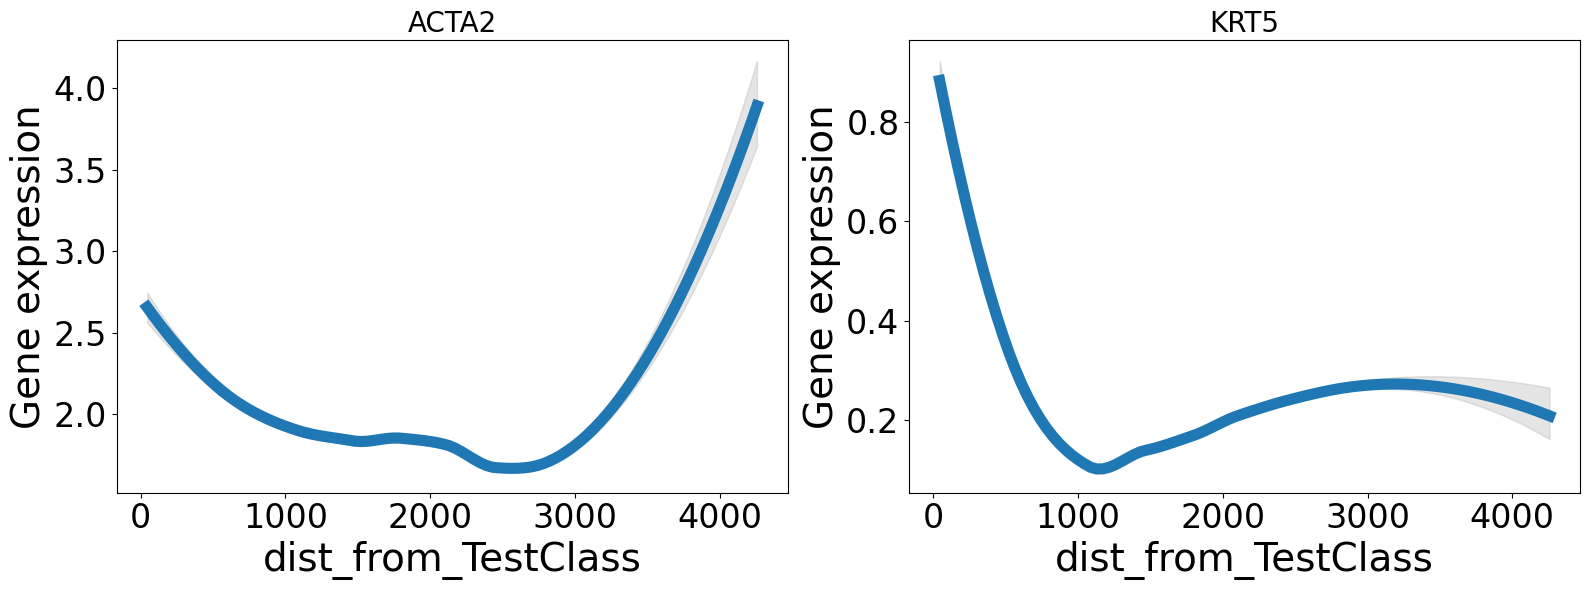

In [125]:
insitupy.pl.expr_along_obs_val(
    adata=xd.cells.matrix, keys=[
        "ACTA2",
        "KRT5"
        ], x_category="dist_from_TestClass", stderr=True
)

In [14]:
x = xd.cells.matrix.obsm["spatial"][:, 0]
y = xd.cells.matrix.obsm["spatial"][:, 1]
cells = gpd.points_from_xy(x, y)

In [15]:
xd.annotations.TestKey

,objectType,geometry,name,color,origin,scale,layer_type
id,,,,,,,
c7b0d4ad-3230-4280-87ae-b66d89f83e63,annotation,"POLYGON ((8275.81844 11472.24074, 7974.48679 1...",TestClass,"[255, 0, 0]",manual,"[0.2125, 0.2125]",Shapes
0013dcb8-fe8f-493e-b87b-23b5b66f715d,annotation,"POLYGON ((12856.05955 12617.30102, 12494.46156...",TestClass,"[255, 0, 0]",manual,"[0.2125, 0.2125]",Shapes
515a1477-7b4d-4fe2-8602-997f9e200e61,annotation,"POLYGON ((17617.09964 12798.10001, 17074.70267...",TestClass,"[255, 0, 0]",manual,"[0.2125, 0.2125]",Shapes


In [18]:
from shapely import Point

In [19]:
layer_types = []
for geom in xd.annotations.TestKey["geometry"]:
    if isinstance(geom, Point):
        layer_types.append("Points")
    else:
        layer_types.append("Shapes")

In [20]:
layer_types

['Shapes', 'Shapes', 'Shapes']

In [22]:
from shapely.affinity import scale as scale_func
# retrieve annotation information
annot_df = xd.annotations.get(annotation_key)
class_df = annot_df[annot_df["name"] == annotation_class]

# calculate distance of cells to their closest point
scaled_geometries = [
    scale_func(geometry, xfact=scale[0], yfact=scale[1], origin=(0,0))
    for geometry, scale in zip(class_df["geometry"], class_df["scale"])
    ]
dists = np.array([cells.distance(geometry) for geometry in scaled_geometries])
min_dists = dists.min(axis=0)

In [23]:
type(xd)

insitupy._core.insitudata.InSituData

In [24]:
from insitupy import InSituData
def calc_distance_of_cells_from(
    data: InSituData,
    annotation_key: str,
    annotation_class: str,
    key_to_save: str = None
    ):

    # create geopandas points from cells
    x = data.cells.matrix.obsm["spatial"][:, 0]
    y = data.cells.matrix.obsm["spatial"][:, 1]
    cells = gpd.points_from_xy(x, y)

    # retrieve annotation information
    annot_df = data.annotations.get(annotation_key)
    class_df = annot_df[annot_df["name"] == annotation_class]

    # calculate distance of cells to their closest point
    scaled_geometries = [
        scale_func(geometry, xfact=scale[0], yfact=scale[1], origin=(0,0))
        for geometry, scale in zip(class_df["geometry"], class_df["scale"])
        ]
    dists = np.array([cells.distance(geometry) for geometry in scaled_geometries])
    min_dists = dists.min(axis=0)

    # add results to CellData
    if key_to_save is None:
        key_to_save = f"dist_from_{annotation_class}"
    data.cells.matrix.obs[key_to_save] = min_dists
    print(f'Save distances to `.cells.matrix.obs["{key_to_save}"]`')



In [28]:
calc_distance_of_cells_from(data=xd,
                            annotation_key="TestKey",
                            annotation_class="TestClass",
                            )

Save distances to `.cells.matrix.obs["dist_from_TestClass"]`


In [29]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'dist_from_points', 'dist_from_TestClass'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       TestKey:	3 annotations, 1 class ('TestClass') 

In [65]:
xd.show()

In [60]:
import insitupy

In [61]:
from insitupy.plotting import expr_along_obs_val

ImportError: cannot import name 'expr_along_obs_val' from 'insitupy.plotting' (unknown location)

In [31]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_TestClass", groupby=None, return_data=True,
                   stderr=False, nsteps=10
                   )

In [35]:
xd.show()

In [32]:
data

x    y_pred    std
key                                       
ACTA2 None 0   498.630160  2.062105  False
           1   997.260321  2.033530  False
           2  1495.890481  1.873122  False
           3  1994.520641  1.633475  False
           4  2493.150801  1.552308  False
           5  2991.780962  1.808473  False
           6  3490.411122  2.283438  False
           7  3989.041282  2.972634  False

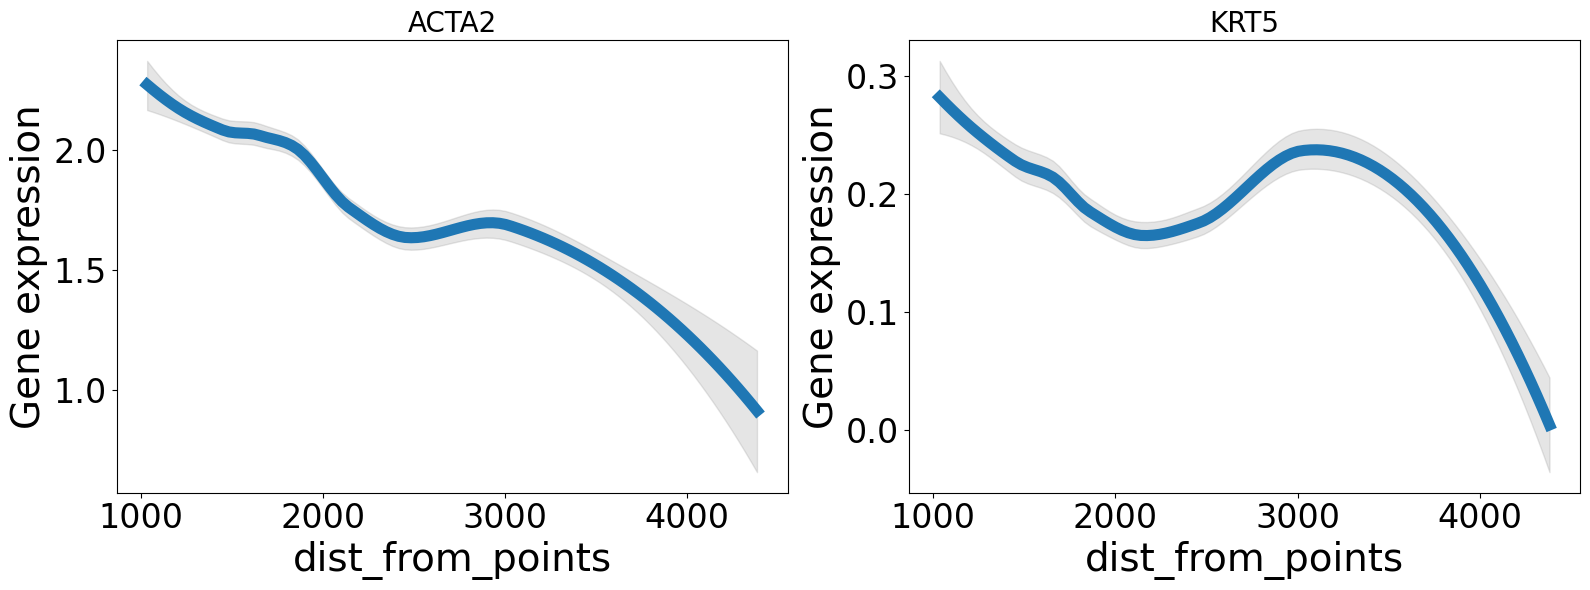

In [36]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=True, nsteps=100, plot_legend=False, xmax=1000
                   )

<Axes: xlabel='distance', ylabel='expression'>

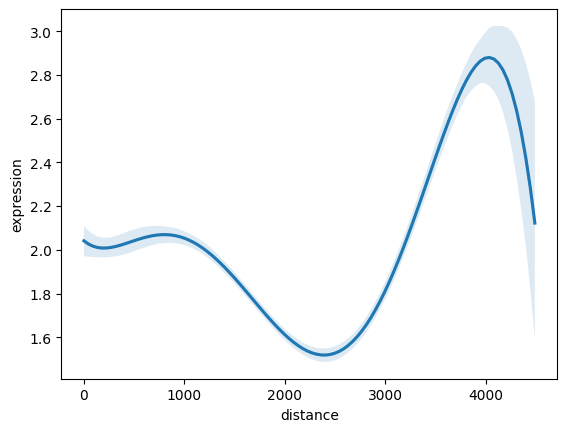

In [ ]:
sns.regplot(data=df, x="distance", y="expression", order=5, scatter=False)

In [37]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'dist_from_points', 'dist_from_TestClass'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       TestKey:	3 annotations, 1 class ('TestClass') 

In [38]:
xd.show()

## Test regplot

In [39]:
import seaborn as sns

In [49]:
gene_id = xd.cells.matrix.var_names.get_loc("ACTA2")
expr = xd.cells.matrix.X[:, gene_id].toarray().T[0]

In [50]:
expr

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [51]:
df = pd.DataFrame({"distance": xd.cells.matrix.obs["dist_from_TestClass"],
                   "expression": expr})

In [52]:
df

,distance,expression
1,2181.170755,0.0
2,2189.467460,0.0
3,2175.568065,0.0
4,2184.992265,0.0
5,2178.641216,0.0
...,...,...
167776,4105.149825,1.0
167777,4128.726409,1.0
167778,4120.151564,1.0
167779,4131.279255,0.0


In [34]:
xd.cells.matrix.obs

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,annotation-demo,annotation-demo2,dist_from_points,dist_from_TestClass
1,28,1,0,29,58.387031,26.642188,NaN,NaN,2430.108111,2181.170755
2,94,0,0,94,197.016719,42.130781,NaN,NaN,2437.209760,2189.467460
3,9,0,0,9,16.256250,12.688906,NaN,NaN,2424.432420,2175.568065
4,11,0,0,11,42.311406,10.069844,NaN,NaN,2432.471467,2184.992265
5,48,0,0,48,107.652500,37.479688,NaN,NaN,2427.070861,2178.641216
...,...,...,...,...,...,...,...,...,...,...
167776,229,1,0,230,220.452813,60.599688,NaN,NaN,1288.446510,4105.149825
167777,79,0,0,79,37.389375,25.242344,NaN,NaN,1308.526830,4128.726409
167778,397,0,0,397,287.058281,86.700000,NaN,NaN,1302.580629,4120.151564
167779,117,0,0,117,235.354375,25.197188,NaN,NaN,1314.475574,4131.279255


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


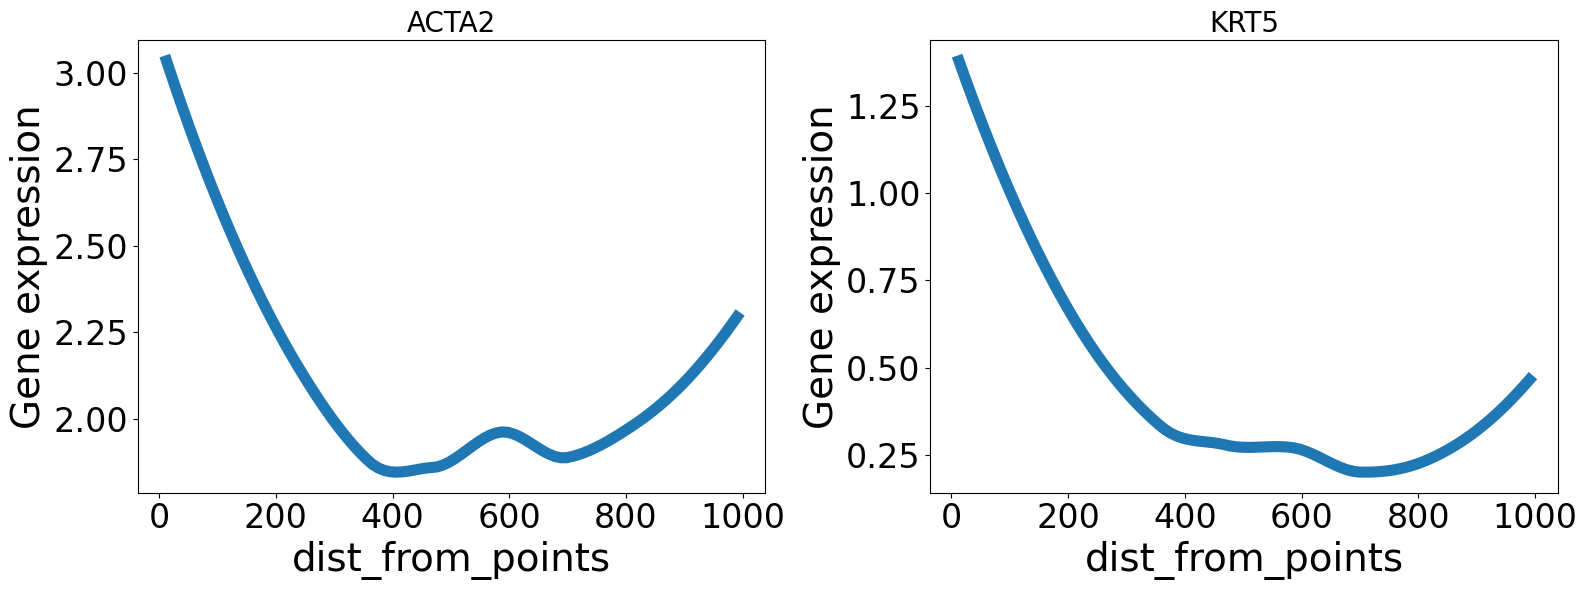

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=False, nsteps=100, plot_legend=False, xmax=1000
                   )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


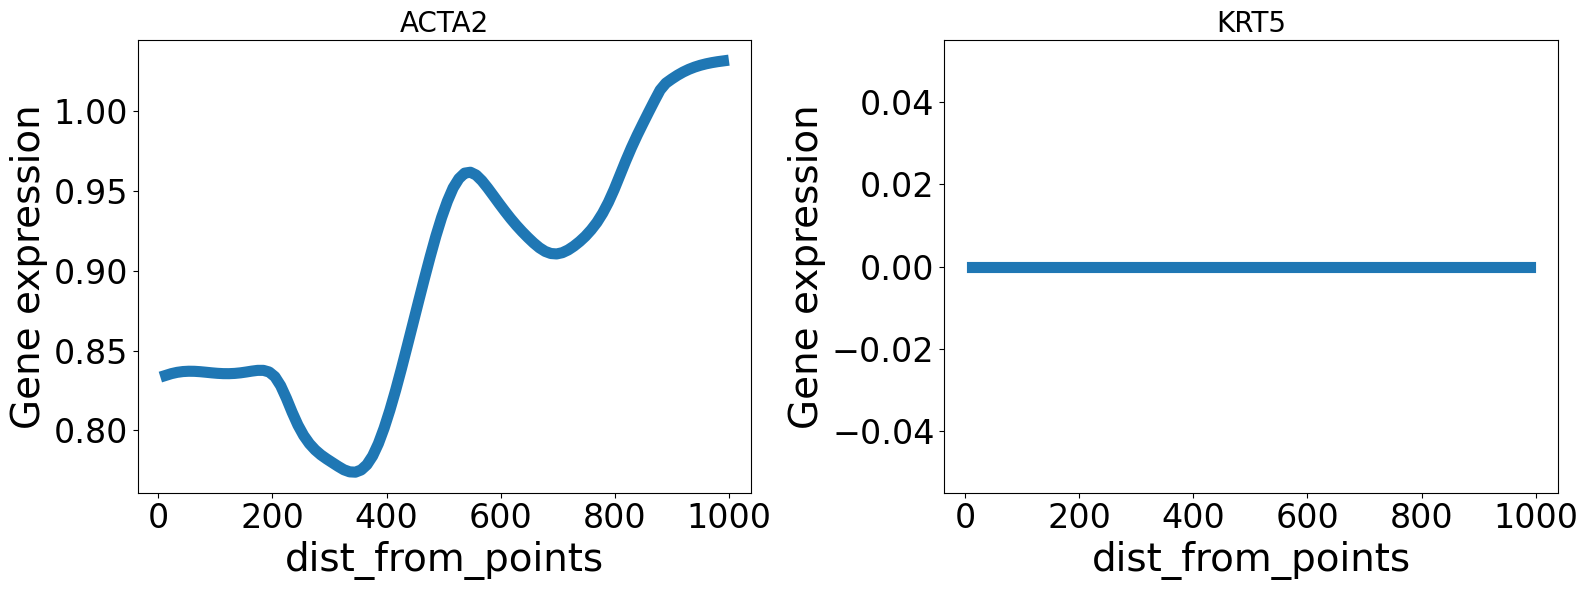

In [23]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"], x_category="dist_from_points",
                   groupby=None, return_data=False,
                   method="lowess", stderr=False,
                   nsteps=100, plot_legend=False, xmax=1000
                   )

## Problems

1. `loess` makes the kernel crash when calculating the stderr
2. `lowess` custom function takes extremely low when calculating the stderr and when skipping stderr also takes very long plus produces weird results.

## Possible solution
1. use `loess` with custom bootstrapping as done in the custom `lowess` function. Should work definitely and not take too long since the `loess` prediction seems to be very fast.

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"], x_category="dist_from_points",
                   groupby=None, return_data=False,
                   method="lowess", stderr=True,
                   nsteps=100, plot_legend=False, xmax=1000
                   )

KeyboardInterrupt: 

Exception ignored in: 'statsmodels.nonparametric._smoothers_lowess.calculate_weights'
Traceback (most recent call last):
  File "c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
KeyboardInterrupt: 


<Axes: xlabel='x'>

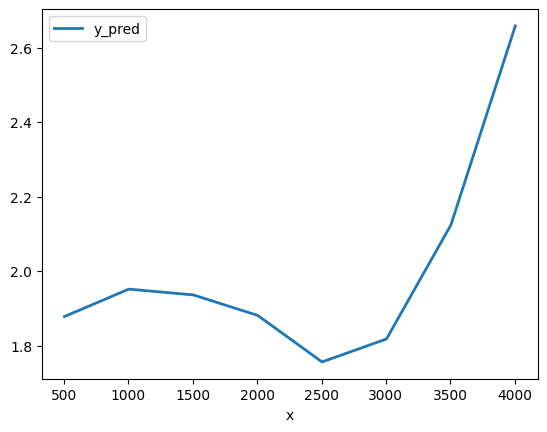

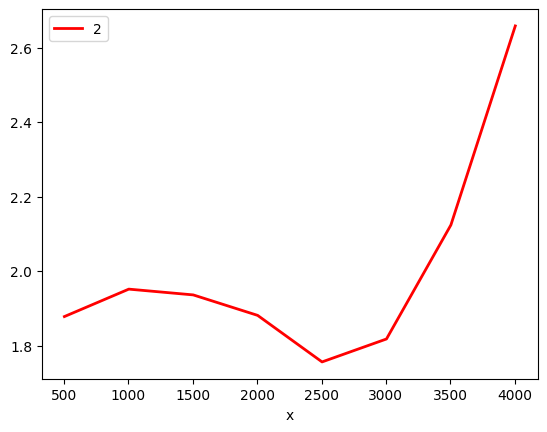

In [41]:
xd.plot(kind="line", x="x", y="y_pred", label=None, color=None, linewidth=2)
xd.plot(kind="line", x="x", y="y_pred", label="2", color="red", linewidth=2)

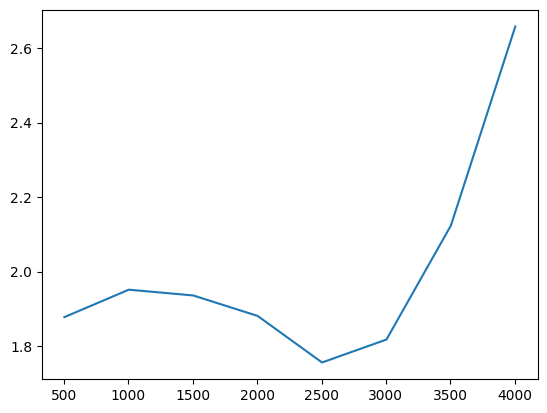

In [32]:
plt.plot(xd["x"], xd["y_pred"])

In [30]:
xd.columns

Index(['x', 'y_pred', 'std', 'conf_lower', 'conf_upper'], dtype='object')

In [23]:
xd

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   504.257656  1.877883  False         NaN         NaN
           1  1004.245360  1.951516  False         NaN         NaN
           2  1504.233064  1.936031  False         NaN         NaN
           3  2004.220768  1.881070  False         NaN         NaN
           4  2504.208473  1.756132  False         NaN         NaN
           5  3004.196177  1.817721  False         NaN         NaN
           6  3504.183881  2.123669  False         NaN         NaN
           7  4004.171585  2.658033  False         NaN         NaN

In [27]:
ls, xs_pred = xd

In [30]:
pred =  ls.predict(xs_pred, stderror=False)

: 

In [29]:
pred.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [24]:
xd.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [23]:
xd

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   479.806029  2.100595  False         NaN         NaN
           1   958.483608  1.943201  False         NaN         NaN
           2  1437.161187  1.921318  False         NaN         NaN
           3  1915.838766  1.826385  False         NaN         NaN
           4  2394.516345  1.634902  False         NaN         NaN
           5  2873.193924  1.797144  False         NaN         NaN
           6  3351.871503  2.273278  False         NaN         NaN
           7  3830.549082  3.041486  False         NaN         NaN

In [33]:
xs

NameError: name 'xs' is not defined

ValueError: setting an array element with a sequence.

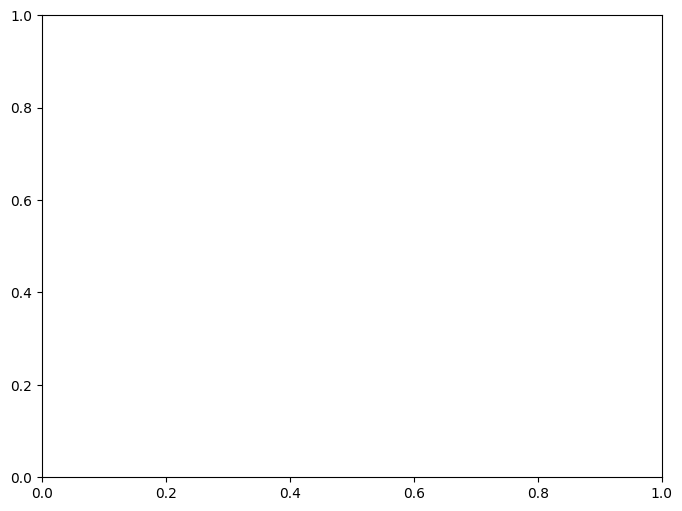

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

ValueError: setting an array element with a sequence.

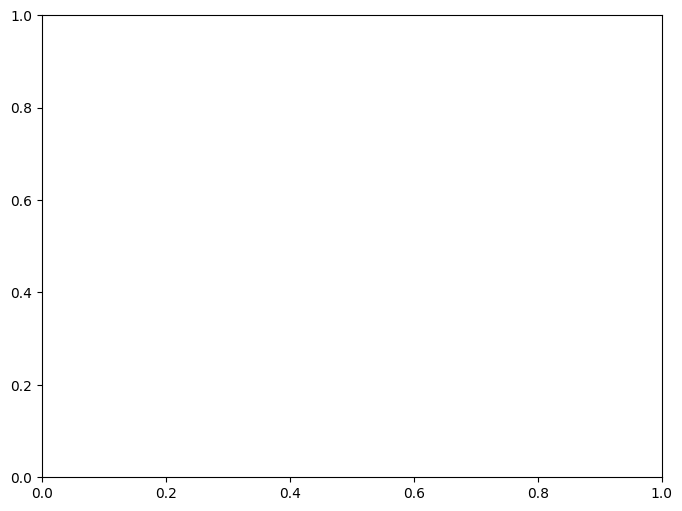

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

In [ ]:
a

In [19]:
dists.shape

(8, 167780)

In [13]:
points

<GeometryArray>
[<POINT (1910.078 2939.854)>, <POINT (2054.715 2852.311)>,
 <POINT (1872.015 2585.873)>, <POINT (1970.978 3210.098)>,
 <POINT (2225.996 3164.423)>,  <POINT (2069.94 3377.573)>,
  <POINT (2770.289 2974.11)>, <POINT (5278.293 1273.736)>]
Length: 8, dtype: geometry

In [12]:
dist.min()

10.316043603539608

In [91]:
dist

array([2840.97583443, 2847.16676686, 2835.26350056, ..., 5964.1267676 ,
       5974.66129396, 5983.51357957])

In [92]:
from shapely import LineString

In [93]:
ll.data[0]

array([[ 7264.325411  , 28308.07095047],
       [ 7743.80240649, 27436.29459505],
       [ 9182.23339293, 26491.87021001],
       [10577.0755616 , 24922.67277026],
       [11812.09206511, 23992.77799114],
       [13250.52305156, 23760.30429636]])

In [94]:
line_coords_xy = np.flip(ll.data[0], axis=1) * pixel_size

In [95]:
line = LineString(line_coords_xy)

In [96]:
cells.distance(line)

array([4779.33797023, 4797.11646734, 4775.46252531, ..., 3341.75590766,
       3353.85023477, 3358.49688704])

In [97]:
xd.cells.matrix.obs["line"] = cells.distance(line)
xd.cells.matrix.obs["line2"] = cells.distance(line)**2

In [82]:
xd.show()

In [99]:
adata = xd.cells.matrix

In [100]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'line', 'line2'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    varm: 'binned_expression'

In [102]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 1., 5., ..., 0., 0., 3.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 1., 3., ..., 0., 0., 0.]], dtype=float32)

In [103]:
adata.obs

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,annotation-demo,annotation-demo2,line,line2
1,28,1,0,29,58.387031,26.642188,NaN,NaN,4779.337970,2.284207e+07
2,94,0,0,94,197.016719,42.130781,NaN,NaN,4797.116467,2.301233e+07
3,9,0,0,9,16.256250,12.688906,NaN,NaN,4775.462525,2.280504e+07
4,11,0,0,11,42.311406,10.069844,NaN,NaN,4796.173524,2.300328e+07
5,48,0,0,48,107.652500,37.479688,NaN,NaN,4781.829921,2.286590e+07
...,...,...,...,...,...,...,...,...,...,...
167776,229,1,0,230,220.452813,60.599688,NaN,NaN,3328.190758,1.107685e+07
167777,79,0,0,79,37.389375,25.242344,NaN,NaN,3346.342668,1.119801e+07
167778,397,0,0,397,287.058281,86.700000,NaN,NaN,3341.755908,1.116733e+07
167779,117,0,0,117,235.354375,25.197188,NaN,NaN,3353.850235,1.124831e+07


In [104]:
adata.var

,gene_ids,feature_types,genome
ABCC11,ENSG00000121270,Gene Expression,Unknown
ACTA2,ENSG00000107796,Gene Expression,Unknown
ACTG2,ENSG00000163017,Gene Expression,Unknown
ADAM9,ENSG00000168615,Gene Expression,Unknown
ADGRE5,ENSG00000123146,Gene Expression,Unknown
...,...,...,...
VWF,ENSG00000110799,Gene Expression,Unknown
WARS,ENSG00000140105,Gene Expression,Unknown
ZEB1,ENSG00000148516,Gene Expression,Unknown
ZEB2,ENSG00000169554,Gene Expression,Unknown


In [44]:
xd.store_annotations()

Added 1 new annotations to key 'test'


In [46]:
xd.annotations.test

,objectType,geometry,name,color,origin
id,,,,,
5af017cc-02a8-4644-8687-7f07f4591693,annotation,"POLYGON ((6021.63193 1559.75951, 5801.00825 16...",blubb,"[255, 0, 0]",manual


In [47]:
xd.show()

In [42]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

In [62]:
l = xd.viewer.layers["Shapes"]
l2 = xd.viewer.layers["*blubb (test)"]
p = xd.viewer.layers["Points"]

In [56]:
l.shape_type

['path']

In [58]:
l2.shape_type

['polygon', 'polygon', 'path']

In [60]:
type(l2)

napari.layers.shapes.shapes.Shapes

In [61]:
type(l)

napari.layers.shapes.shapes.Shapes

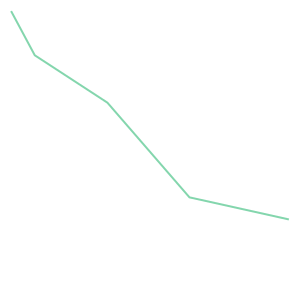

In [34]:
LineString(ll.data[0])

In [17]:
ll.data[0]

array([[ 7282.3753437 , 28338.57000552],
       [ 7817.66894886, 27339.35527589],
       [ 9459.23600467, 26268.76806558],
       [11314.92050255, 24127.59364495],
       [13563.15364421, 23627.98628013]])

In [22]:
ll.data[0][:, 0]

array([ 7282.3753437 ,  7817.66894886,  9459.23600467, 11314.92050255,
       13563.15364421])

In [24]:
s = gpd.points_from_xy(ll.data[0][:, 1], ll.data[0][:, 0])

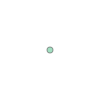

In [25]:
s[0]